### Import modules

In [2]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Read data

In [3]:
# Get image and plot
imgPath = (r'D:\deeplearning\data\s2_sample.tif')
img = rio.open(imgPath)
dn_arr = img.read()
print(dn_arr.shape, type(dn_arr))

(12, 517, 722) <class 'numpy.ndarray'>


In [4]:
# Get the full image that will be classified later using the trained model

fullimgPath = (r'D:\deeplearning\data\s2_01_resampled_subset.tif')
fullimg = rio.open(fullimgPath)
full_arr = fullimg.read()
print(full_arr.shape, type(full_arr))

(12, 4270, 6120) <class 'numpy.ndarray'>


#### Convert digital numbers into surface reflectance

In [5]:
# Sentinel-2A will need to be quantified to gain the surface reflectance value
q = 10000 # Sentinel-2 quantification value

fullsr_arr = (full_arr / q).astype(float)
print(fullsr_arr.shape, type(fullsr_arr))

sr_arr = (dn_arr / q).astype(float)
print(sr_arr.shape, type(sr_arr))

(12, 4270, 6120) <class 'numpy.ndarray'>
(12, 517, 722) <class 'numpy.ndarray'>


### Visualize Data

#### Bands

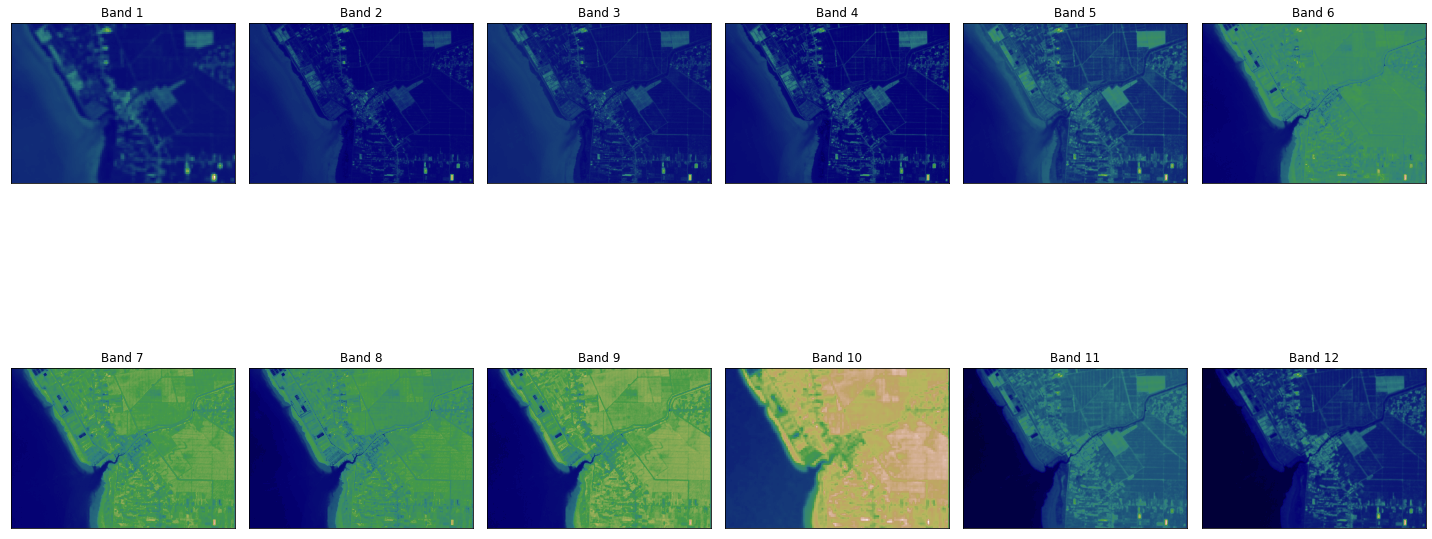

In [6]:
# Visualize the data
ep.plot_bands(sr_arr, cmap='gist_earth', figsize = (20, 12), cols = 6, cbar = False)
plt.show()

#### RGB Composite Image

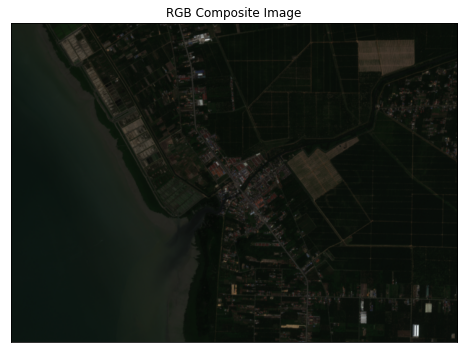

In [7]:
rgb = ep.plot_rgb(sr_arr,
                 rgb = (3, 2, 1), # True color composite
                 figsize = (8, 10),
                 title = 'RGB Composite Image'
                 )
plt.show()

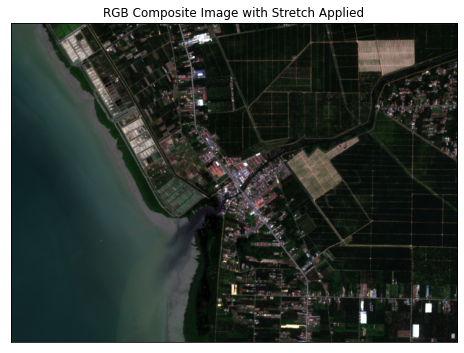

In [9]:
ep.plot_rgb(
    sr_arr,
    rgb = (3, 2, 1),
    stretch = True,
    str_clip = 0.2,
    figsize = (8, 10),
    title = 'RGB Composite Image with Stretch Applied',
)

plt.show()

### Data Distribution of Bands

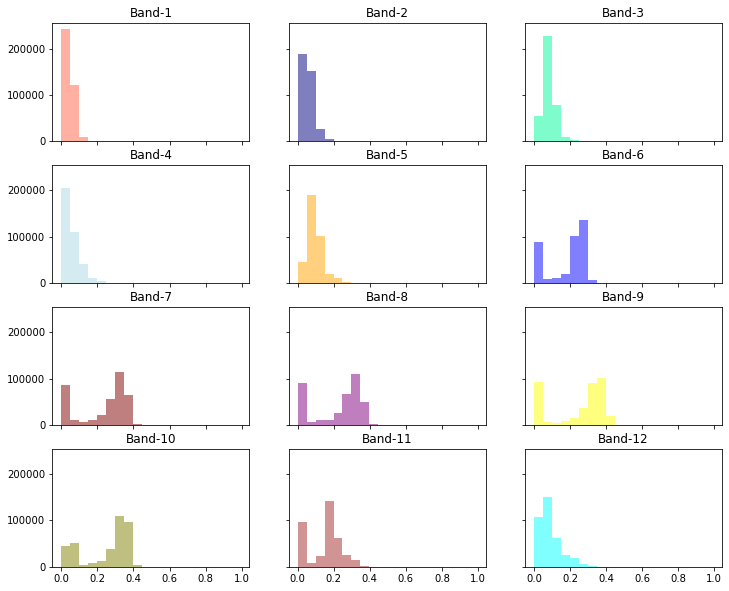

In [8]:
colors = ['tomato', 'navy','MediumSpringGreen', 'lightblue', 'orange', 'blue', 
         'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(sr_arr, 
        colors = colors, 
        title = [f'Band-{i}' for i in range(1, 13)], 
        cols = 3,
        alpha = 0.5,
        figsize = (12, 10)
       )

plt.show() 

### Preprocessing

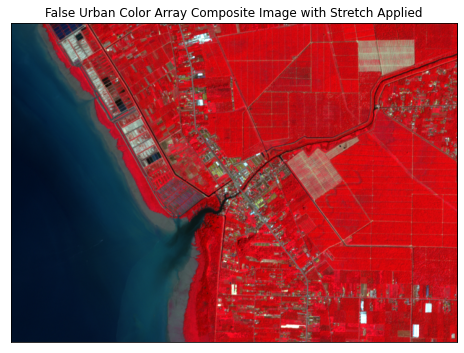

In [9]:
# Surface reflectance for true image composite
true_arr = sr_arr[1:4] #true image composite

# Extracting bands for other composites
blue = sr_arr[1]
green = sr_arr[2]
red = sr_arr[3]
nir = sr_arr[7]

falseUR_arr = np.dstack((nir, red, green)) # false urban image composite


ep.plot_rgb(
    sr_arr, #use the sr_array composite and call the concerned bands only for viewing
    rgb = (7, 3, 2),
    stretch = True,
    str_clip = 0.2,
    figsize = (8, 10),
    title = 'False Urban Color Array Composite Image with Stretch Applied',
)

plt.show()

In [12]:
# Create the stack of full image data we would like to predict with the trained model
full_blue = fullsr_arr[1]
full_green = fullsr_arr[2]
full_red = fullsr_arr[3]
full_nir = fullsr_arr[7]

true_full = np.dstack((full_red, full_green, full_blue))
falseur_full = np.dstack((full_nir, full_red, full_green))

In [40]:
x = np.moveaxis(true_arr, 0, -1)
print(x.shape)

(517, 722, 3)


In [52]:
x_full = np.moveaxis(true_full, 0, -1)
print(x_full.shape)

NameError: name 'true_full' is not defined

#### Standardize the scale of satellite image numpy array

In [41]:
from sklearn.preprocessing import StandardScaler

x_data = x.reshape(-1, 3) 
scaler = StandardScaler().fit(x_data)
x_scaled = scaler.transform(x_data) # turns the numpy array into height*width with 3 columns 

print(x_scaled.shape)

(373274, 3)


### Read ground truth data

In [42]:
gtPath = (r'D:\deeplearning\script\output\A01_output_kmeans_6class_newdatasetFU.tif')
gt_image = rio.open(gtPath)
y_data = gt_image.read()
print(y_data.shape)
print('Unique values in training array: ', np.unique(y_data))

(1, 517, 722)
Unique values in training array:  [0 1 2 3 4 5]


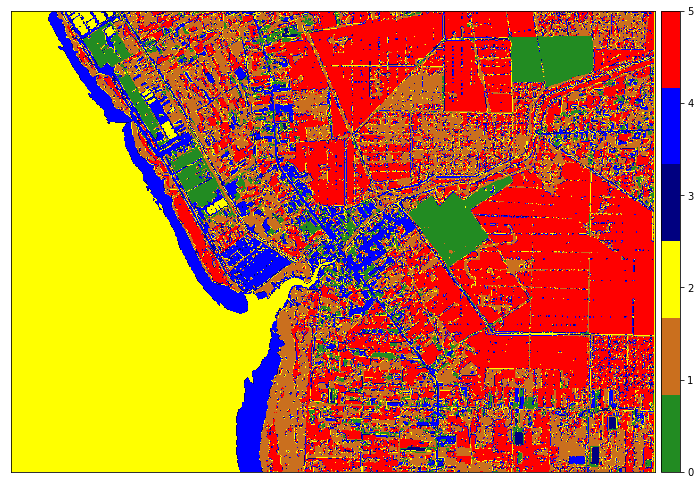

In [43]:
ep.plot_bands(y_data, cmap=ListedColormap(['forestgreen', '#CA6F1E', 'yellow', 'navy', 'blue', 'red']))
plt.show()

### Train Test Split

In [44]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_data.ravel(), test_size = 0.2, stratify = y_data.ravel())

print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train: {y_train.shape}\ny_test shape: {y_test.shape}')

x_train shape: (298619, 3)
x_test shape: (74655, 3)
y_train: (298619,)
y_test shape: (74655,)


### Machine learning algorithm implementation

The process of classification involves:
1. The configuration of the parameters of the classifiers being used - assigned to a variable
2. The fitting and training of the configured classifier with training image and label data; x_train and y_train
3. The trained model is then used to predict the image test dataset; x_test

#### Importing library for accuracy scoring and Intel(R) Extension to speed the `scikit-learn` application

In [45]:
from sklearn.metrics import accuracy_score, classification_report
#from sklearnex import patch_sklearn

#patch_sklearn()
# sklearnex.unpatch_sklearn()to unpatch

#### K-Nearest Neighbor Classifier (kNN)

In [46]:
# Importing the classifier from scikit learn library
from sklearn.neighbors import KNeighborsClassifier

# Configurating the kNN classifier
knn = KNeighborsClassifier(n_neighbors=6)

# Fitting and training the kNN algorithm with x and y training data
knn.fit(x_train, y_train)

# The trained `knn` kNN classifier is tested on x_test data that has been set aside to evaluate its accuracy
knn_pred = knn.predict(x_test)

In [47]:
# The accuracy of the model is checked where the predictions for x_test data (not named but considered y_predict) is evaluated
# against the ground truth y_test data that has been set aside for comparison
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

Accuracy: 78.21043466613087


In [48]:
# The classification performance report is generated
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4743
           1       0.60      0.68      0.64     18609
           2       0.97      0.98      0.98     19589
           3       0.97      0.97      0.97       185
           4       0.76      0.63      0.69      7061
           5       0.77      0.72      0.74     24468

    accuracy                           0.78     74655
   macro avg       0.83      0.81      0.82     74655
weighted avg       0.79      0.78      0.78     74655



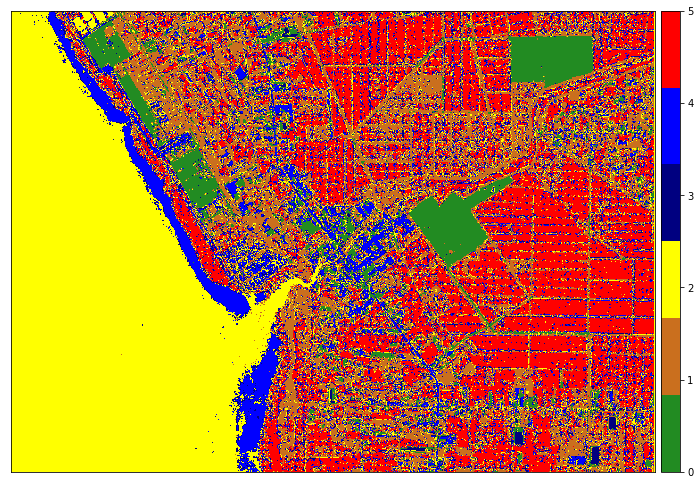

In [49]:
# The full scaled image to be analyzed is classified, reshaped to its original shape and plotted for visualization
ep.plot_bands(knn.predict(x_scaled).reshape((517, 722)),
             cmap=ListedColormap(['forestgreen', '#CA6F1E', 'yellow', 'navy', 'blue', 'red']))
plt.show()

#### Support Vector Machine (SVM)

In [50]:
from sklearn.svm import SVC

# Initialize our model with default configuration
svm = SVC(verbose=True)
#svm = SVC(C = 3.0, kernel = 'rbf', degree = 6, cache_size = 1024)

# Fit our initialized model to the training data
svm.fit(x_train, y_train)

[LibSVM]

SVC(verbose=True)

In [51]:
svm_pred = svm.predict(x_test)

In [53]:
print(f'Accuracy: {accuracy_score(y_test, svm_pred)*100}')

Accuracy: 79.34900542495478


In [ ]:
ep.plot_bands(svm.predict(x_scaled).reshape((517, 722)),
             cmap=ListedColormap(['forestgreen', '#CA6F1E', 'yellow', 'navy', 'blue', 'red']))
plt.show()

#### Random Forest (RF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators = 500, oob_score = True)

print('Our OOB prediction of accuracy is: {oob}%'.format(oob = rf.oob_score_ * 100))

print(rf.score(x_test, y_test))



#### Light BGM

In [ ]:
import lightbgm as lgb

d_train = lgb.Dataset(x_train, label = y_train)

params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt' # Gradient Boosting Decision Tree
params['objective'] = 'multiclass' # Multi-class target feature
params['metric'] = 'multi_logloss' # Metric for multi-class
params['max_depth'] = 15
params['num_class'] = 6 # number of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)